# Install dependences

In [17]:
# install the latest kashgari
#!pip uninstall -y kashgari
#!pip install git+https://github.com/BrikerMan/Kashgari@v2-dev
!pip install hanziconv
!pip install segtok

Uninstalling kashgari-2.0.0a0:
  Successfully uninstalled kashgari-2.0.0a0
  Cloning https://github.com/BrikerMan/Kashgari (to revision v2-dev) to /tmp/pip-req-build-xg1vfqpv
  Running command git clone -q https://github.com/BrikerMan/Kashgari /tmp/pip-req-build-xg1vfqpv
  Running command git checkout -b v2-dev --track origin/v2-dev
  Switched to a new branch 'v2-dev'
  Branch 'v2-dev' set up to track remote branch 'v2-dev' from 'origin'.
  Created wheel for kashgari: filename=kashgari-2.0.0a0-cp36-none-any.whl size=76877 sha256=4efbfddb4bd9aeb76ea1c88d79e32322df6476fc18a8ad539a770ca2da42a2cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-5u7oa3ha/wheels/a9/03/76/529f1de0a5a77e3953f62283da282f8f9ae35273876cf8e535
Successfully built kashgari


## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/ This dataset contains language translation pairs in the format:

```
I'm on Tom's side.	我站在湯姆一邊。	CC-BY 2.0 (France) Attribution: tatoeba.org #2549046 (CK) & #6065739 (verdastelo9604)
```

There are a variety of languages available, but we'll use the English-Chinese dataset. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.

In [0]:
# Setup data path
DATA_PATH = 'cmn.txt'

In [2]:
import pandas as pd
from hanziconv import HanziConv
from segtok.tokenizer import word_tokenizer

import tensorflow as tf

df = pd.read_csv(DATA_PATH, header=None, sep='\t')

df.columns = ['en', 'cn', 'cc']

df['cn'] = df['cn'].apply(lambda x: HanziConv.toSimplified(x))
df['en_cutted'] = df['en'].apply(lambda x: word_tokenizer(x.lower()))
df['cn_cutted'] = df['cn'].apply(lambda x: list(x))
df.head()

,en,cn,cc,en_cutted,cn_cutted
0,Hi.,嗨。,CC-BY 2.0 (France) Attribution: tatoeba.org #5...,"[hi, .]","[嗨, 。]"
1,Hi.,你好。,CC-BY 2.0 (France) Attribution: tatoeba.org #5...,"[hi, .]","[你, 好, 。]"
2,Run.,你用跑的。,CC-BY 2.0 (France) Attribution: tatoeba.org #4...,"[run, .]","[你, 用, 跑, 的, 。]"
3,Wait!,等等！,CC-BY 2.0 (France) Attribution: tatoeba.org #1...,"[wait, !]","[等, 等, ！]"
4,Wait!,等一下！,CC-BY 2.0 (France) Attribution: tatoeba.org #1...,"[wait, !]","[等, 一, 下, ！]"


In [3]:
input_datas = df['en_cutted'].values
target_datas = df['cn_cutted'].values

print(f'Input sentence samples  : {input_datas[:3]}')
print(f'Output sentence samples : {target_datas[:3]}')
print(f'Total sentence count    : {len(input_datas)}')

Input sentence samples  : [list(['hi', '.']) list(['hi', '.']) list(['run', '.'])]
Output sentence samples : [list(['嗨', '。']) list(['你', '好', '。']) list(['你', '用', '跑', '的', '。'])]
Total sentence count    : 22075


## Build model and fit

In [4]:
from kashgari.tasks.seq2seq.model import Seq2Seq
model = Seq2Seq()

Seq2Seq API is experimental. It may be changed in the future without notice.


In [0]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model
        self.sample_count = 5

    def on_epoch_end(self, epoch, logs=None):
        import random
        samples = random.sample(list(input_datas), self.sample_count)
        translates, _ = self.model.predict(samples)
        print()
        for index in range(len(samples)):
            print(f"English: {' '.join(samples[index])}")
            print(f"Chinese: {''.join(translates[index])}")
            print('------------------------------')

In [0]:
his_callback = CustomCallback(model)
history = model.fit(input_datas,
                    target_datas,
                    callbacks=[his_callback],
                    epochs=20,
                    batch_size=64)

In [31]:
import random
x = random.sample(list(input_datas), 5)
transalte, attention = model.predict(x, debug_info=True)

for i in range(len(x)):
    print(f"{' '.join(x[i]):<40} -> {''.join(transalte[i])}")


---------------------------
input sentence  : i went there because i wanted to .
input idx       : [  2   6 136  51 304   6 251   7   4   3   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
output idx      : [5, 32, 37, 124, 308, 42, 5, 36, 26]
output sentence : 我 去 那 儿 因 为 我 想

---------------------------
input sentence  : do they love each other ?
input idx       : [  2  23  54 187 529 260  10   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
output idx      : [9, 16, 1270, 533, 141, 109, 22, 14]
output sentence : 他 们 彼 此 相 信 吗

---------------------------
input sentence  : i told tom i was ok .
input idx       : [  2   6 169  13   6  24 828   4   3   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
output idx      : [5, 122, 155, 19, 20, 43, 25, 38, 4]
output sentence : 我 告 诉 汤 姆 说 很 好

---------------------------
input sente

## Visualize

In order to render Chinese, need to install Chinese characters (on Ubuntu / Colab).

In [14]:
# Download the target font
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!mv SimHei.ttf /usr/share/fonts/truetype/

--2020-05-20 14:56:11--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  6.88MB/s    in 1.5s    

2020-05-20 14:56:14 (6.88 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


In [0]:
# function for plotting the attention weights
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

font_name = 'SIMHEI'
plt.rcParams['font.family'] = font_name #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
zhfont = font_manager.FontProperties(fname='/usr/share/fonts/truetype/SimHei.ttf')

# 如果绘制图表不清晰，可以设置高 dpi 来提高图表清晰度
plt.rcParams['figure.dpi'] = 120

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
def plot_attention(attention, sentence, predicted_sentence):
    attention = attention[:,:max(len(sentence), len(predicted_sentence))]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    font_dict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=font_dict, rotation=90, fontproperties=zhfont)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict, fontproperties=zhfont)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate_with_plot(sentence):
    translates, attentions = model.predict([sentence], max_len=10)
    plot_attention(attentions[0], sentence, translates[0])
    print(f"{' '.join(sentence):<40} -> {''.join(translates[0])}")

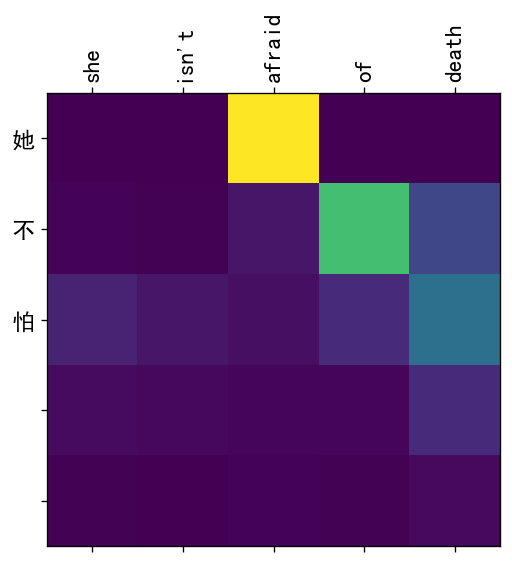

she isn't afraid of death                -> 她不怕


In [64]:
translate_with_plot("she isn't afraid of death".split(' '))

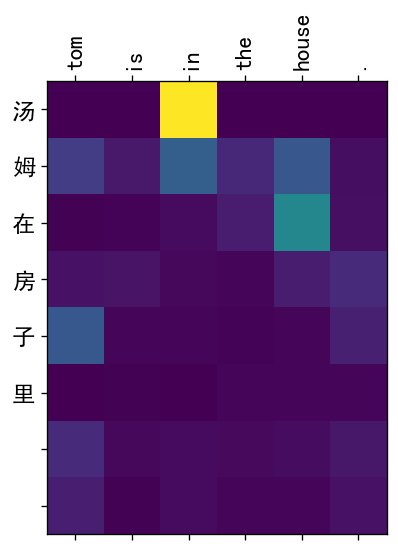

tom is in the house .                    -> 汤姆在房子里


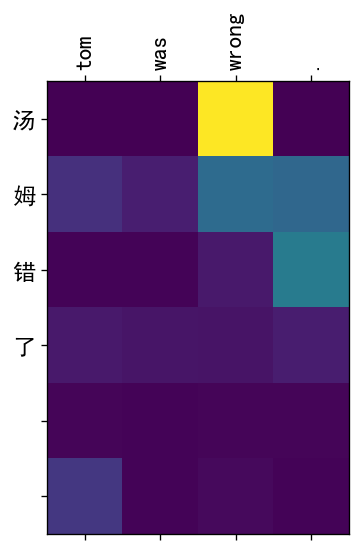

tom was wrong .                          -> 汤姆错了


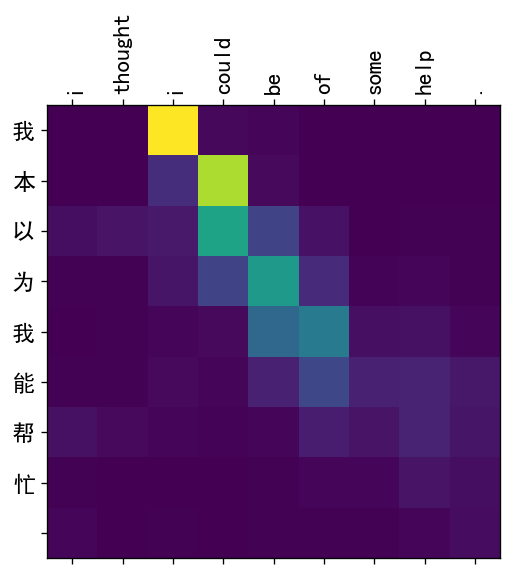

i thought i could be of some help .      -> 我本以为我能帮忙


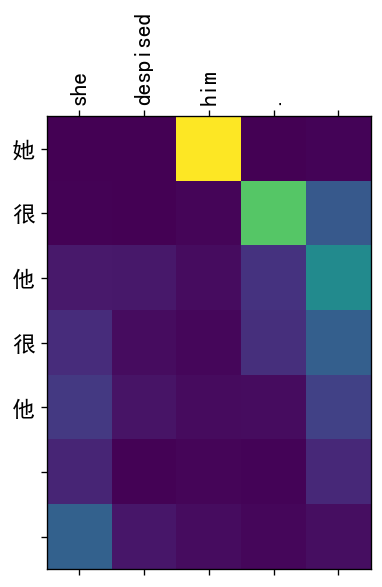

she despised him .                       -> 她很他很他


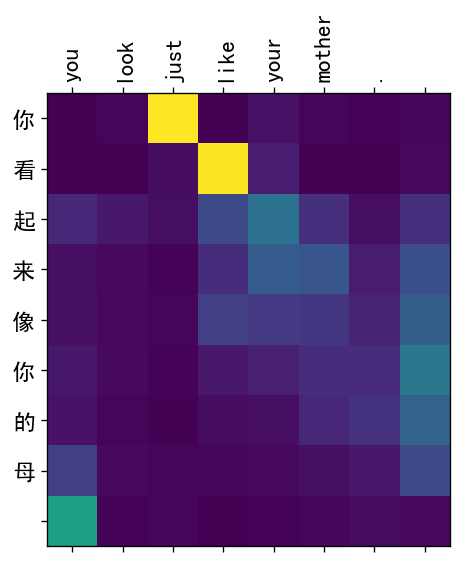

you look just like your mother .         -> 你看起来像你的母


In [66]:
import random

for sentence in random.sample(list(input_datas), 5):
    translate_with_plot(sentence)